In [1]:
import os

import numpy as np  # numerical library
import xarray as xr  # netCDF library
import pandas as pd

import matplotlib.pyplot as plt  # plotting library
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
import cartopy.feature as cfeature

from shapely.geometry import Polygon, Point
from shapely.ops import transform
import pyproj

import cftime

In [2]:
def point_in_polygon(lon, lat, polygon):
    point = Point(lon, lat)
    return polygon.contains(point)

In [3]:
# Define a transformation to ensure the polygon's CRS matches
def transform_polygon(polygon, src_crs='epsg:4326', tgt_crs='epsg:4326'):
    # Transform the polygon to match the DataArray CRS if needed
    proj = pyproj.Transformer.from_proj(pyproj.Proj(src_crs), pyproj.Proj(tgt_crs), always_xy=True)
    return transform(lambda x, y: proj.transform(x, y), polygon)

In [4]:
#To compute de climatoloy
yearC1='1995'
yearC2='2000'

In [5]:
Titulos = ['Demarcación marina levantino-balear', 'Demarcación marina noratlántica','Demarcación marina canaria', 
           'Demarcación sudatlántica','Demarcación Estrecho y Alborán']
Titulos_short = ['LEB', 'NOR','CAN','SUD','ESA']

In [6]:
HOME=os.environ['HOME']   
f = open(HOME+'/.env', 'r')
for line in f.readlines():
    Name=line.strip().split('=')[0]
    Content=line.strip().split('=')[-1]
    if Name=='dirData' or Name=='dirAnalisis':
        exec(Name + "=" + "'" + Content + "'")
f.close()

In [7]:
base_file1 = dirData + '/Climatologias/Glorys/cmems_mod_glo_phy_my_0.083_P1M-m_202311/'
base_file2 = dirData + '/Climatologias/Glorys/cmems_mod_glo_phy_myint_0.083deg_P1M-m_202311/'
dataDir    = dirAnalisis + '/IEOOSWebPage/data'
imageDir   = dirAnalisis + '/IEOOSWebPage/images'

In [8]:
i=2
titulo = Titulos[i]
titulo_short = Titulos_short[i]

In [9]:
# Load the data from the .txt file
demCoord = []
longDem, latiDem = [], []
with open('./LimiteDemarcaciones/Demarcacion'+titulo_short+'.txt', 'r') as f:
    for line in f:
        # Split the line by whitespace and append the values
        longitude, latitude = map(float, line.split())
        longDem.append(longitude)
        latiDem.append(latitude)
        demCoord.append((longitude,latitude))
demPolygon = Polygon(demCoord)    
demPolygon_transformed = transform_polygon(demPolygon)

## Read the data

In [25]:
DC = xr.open_dataset('./Data/Glorys_DC_tempCAN.nc').thetao

In [24]:
DC

<xarray.Dataset> Size: 3GB
Dimensions:    (longitude: 181, latitude: 103, depth: 50, time: 348)
Coordinates:
  * longitude  (longitude) float32 724B -25.0 -24.92 -24.83 ... -10.08 -10.0
  * latitude   (latitude) float32 412B 24.0 24.08 24.17 ... 32.33 32.42 32.5
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * time       (time) datetime64[ns] 3kB 1995-01-16T12:00:00 ... 2023-12-16T1...
Data variables:
    thetao     (time, depth, latitude, longitude) float64 3GB ...

In [31]:
DC_temp = xr.open_dataset('./Data/Glorys_DC_tempCAN.nc').thetao
DC_salt = xr.open_dataset('./Data/Glorys_DC_saltCAN.nc').so

In [32]:
DC_temp_unmasked = xr.open_dataset('./Data/Glorys_DC_temp_unmaskedCAN.nc').thetao
DC_temp_unmasked = xr.open_dataset('./Data/Glorys_DC_salt_unmaskedCAN.nc').so

In [33]:
meanTemp=DC_temp.mean('time').sel(depth=10, method='nearest')
meanTemp_unmasked=DC_temp_unmasked.mean('time').sel(depth=10, method='nearest')

In [34]:
meanTemp_unmasked

<xarray.DataArray 'so' (latitude: 103, longitude: 181)> Size: 149kB
array([[37.14624835, 37.14445056, 37.14225375, ...,         nan,
                nan,         nan],
       [37.15668427, 37.15524166, 37.15307555, ...,         nan,
                nan,         nan],
       [37.16662471, 37.16526541, 37.16334923, ...,         nan,
                nan,         nan],
       ...,
       [36.8113077 , 36.81268455, 36.81370621, ..., 36.50921392,
        36.49206042, 36.47073254],
       [36.80469536, 36.8055241 , 36.80636599, ..., 36.52538523,
        36.51022244, 36.49150793],
       [36.79762699, 36.79774538, 36.79819264, ..., 36.53950881,
        36.5257404 , 36.50941563]])
Coordinates:
  * longitude  (longitude) float32 724B -25.0 -24.92 -24.83 ... -10.08 -10.0
  * latitude   (latitude) float32 412B 24.0 24.08 24.17 ... 32.33 32.42 32.5
    depth      float32 4B 9.573

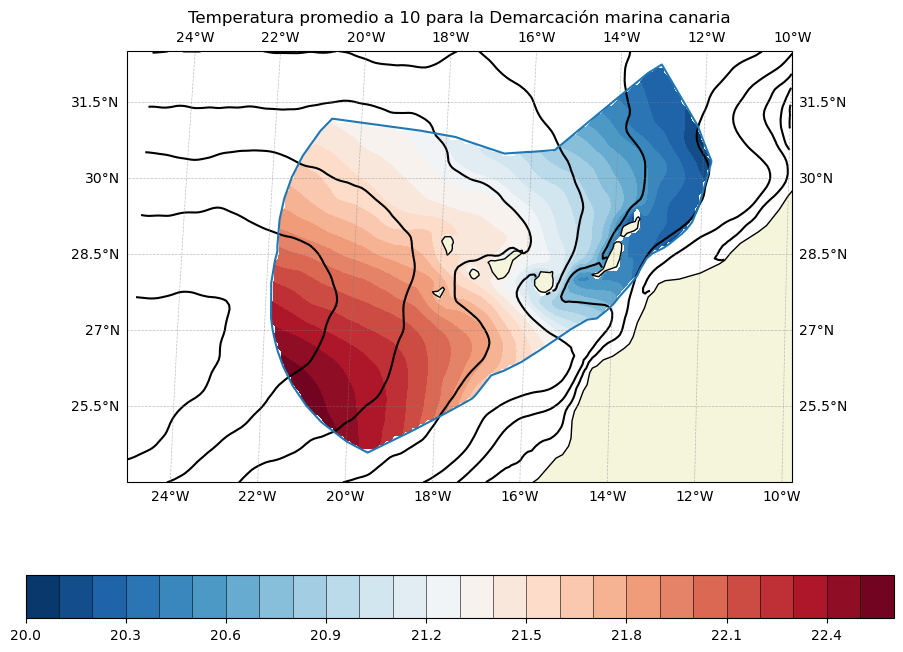

In [67]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

ax.contour(meanTemp_unmasked.longitude,meanTemp_unmasked.latitude,meanTemp_unmasked,10,colors='k',
           transform=ccrs.PlateCarree())


cm = ax.contourf(meanTemp.longitude,meanTemp.latitude,meanTemp,30, 
               transform=ccrs.PlateCarree(),
               cmap = plt.cm.RdBu.reversed())

land = cartopy.feature.NaturalEarthFeature('physical', 'land', edgecolor='k', scale = '50m' ,
        facecolor=cfeature.COLORS['land'])

ax.add_feature(land, facecolor='beige')
    
cbar=fig.colorbar(cm,ax=ax, location='bottom', shrink=.8, drawedges=True)

ax.plot(longDem, latiDem, transform=ccrs.PlateCarree())
ax.gridlines(draw_labels=True, linewidth=.5,color='gray', alpha=0.5, linestyle='--')

ax.top_labels = ax.right_labels = False
ax.set_title('Temperatura promedio a '+'10 '+'para la '+titulo);

plt.savefig(imageDir+'/'+titulo_short+'_temp_promedio'+'10'+'.png')

In [36]:
prof_mean_temp = DC_temp.stack(flat_dim=('longitude', 'latitude','time')).mean('flat_dim')
prof_std_temp  = DC_temp.stack(flat_dim=('longitude', 'latitude','time')).std('flat_dim')

prof_mean_salt = DC_salt.stack(flat_dim=('longitude', 'latitude','time')).mean('flat_dim')
prof_std_salt  = DC_salt.stack(flat_dim=('longitude', 'latitude','time')).std('flat_dim')

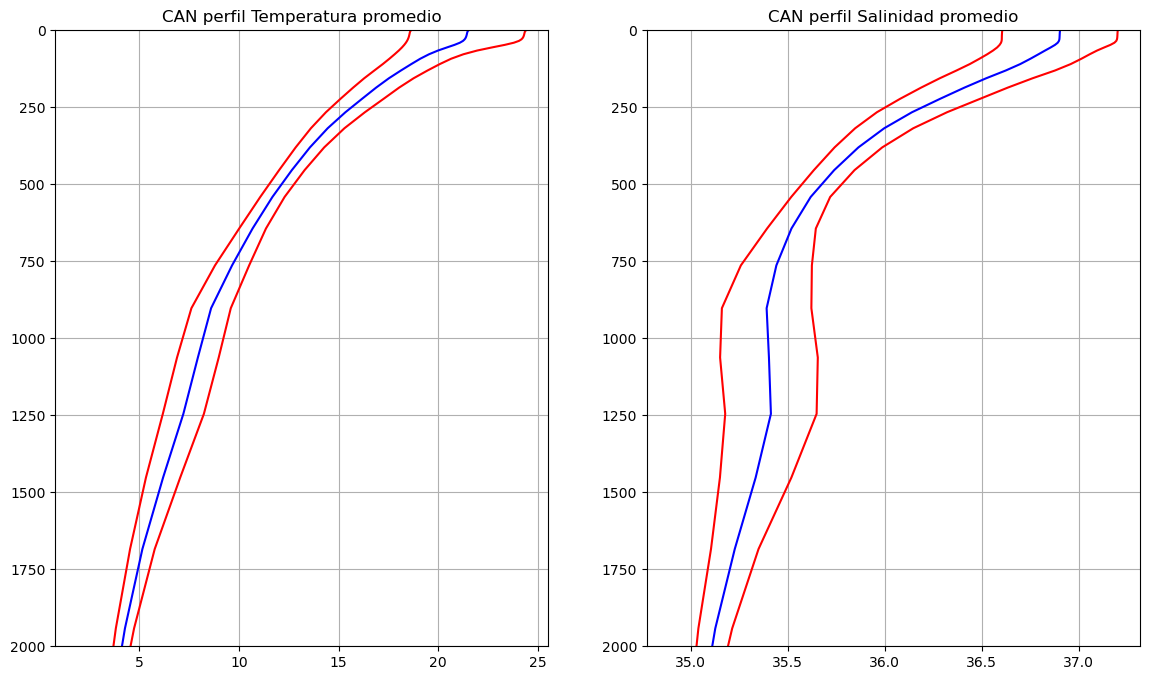

In [68]:
fig,ax= plt.subplots(1,2,figsize=(14,8))

#ax[0].plot(DC_temp.stack(flat_dim=('longitude', 'latitude','time')),DC_temp.depth, color='lightgrey')
ax[0].plot(prof_mean_temp,prof_mean_temp.depth,color='blue')  
ax[0].plot(prof_mean_temp+1.5*prof_std_temp,prof_mean_temp.depth,color='red')  
ax[0].plot(prof_mean_temp-1.5*prof_std_temp,prof_mean_temp.depth,color='red')  
ax[0].invert_yaxis()
ax[0].set_ylim([2000,0]);
ax[0].grid()

#ax[1].plot(DC_salt.stack(flat_dim=('lon', 'lat','time')),DC_temp.depth, color='lightgrey')
ax[1].plot(prof_mean_salt,prof_mean_temp.depth,color='blue')  
ax[1].plot(prof_mean_salt+1.5*prof_std_salt,prof_mean_salt.depth,color='red')  
ax[1].plot(prof_mean_salt-1.5*prof_std_salt,prof_mean_salt.depth,color='red')  
ax[1].invert_yaxis()
ax[1].set_ylim([2000,0]);
ax[1].grid()

ax[0].set_title(titulo_short+' perfil Temperatura promedio');
ax[1].set_title(titulo_short+' perfil Salinidad promedio');

plt.savefig(imageDir+'/'+titulo_short+'_perfiles_T_S_promedio.png')

## Seasonal cycle

In [38]:
#Create monthly climatology
DC_temp_clim = DC_temp.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

In [39]:
DC_salt_clim = DC_salt.sel(time=slice(yearC1,yearC2)).groupby('time.month').mean(dim='time').load();

In [40]:
#Create anomaly
DC_temp_anom = DC_temp.groupby('time.month') - DC_temp_clim
DC_temp_anom.load();

In [41]:
DC_salt_anom = DC_salt.groupby('time.month') - DC_salt_clim
DC_salt_anom.load();

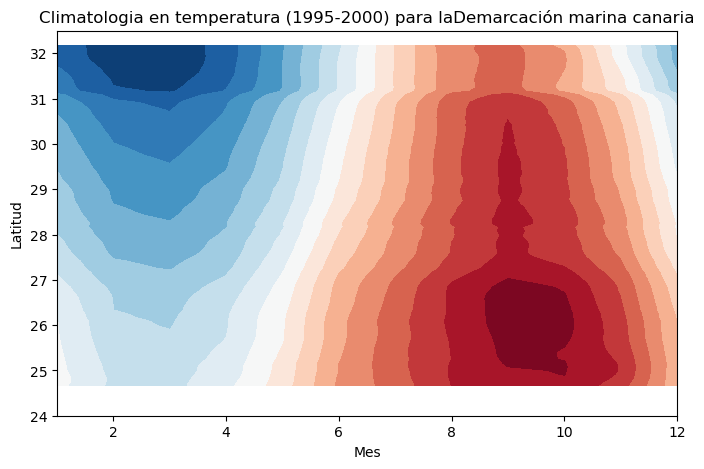

In [71]:
fig, ax = plt.subplots(1, 1 , figsize=(8,5))
ax.contourf(DC_temp_clim.mean(dim='longitude').sel(depth=10, method='nearest').month,
                 DC_temp_clim.mean(dim='longitude').sel(depth=10, method='nearest').latitude,
                 DC_temp_clim.mean(dim='longitude').sel(depth=10, method='nearest').transpose(),20,
            cmap = plt.cm.RdBu.reversed())
ax.grid()

ax.set_ylabel('Latitud') 
ax.set_xlabel('Mes')
ax.set_title('Climatologia en temperatura (' + yearC1 + '-' + yearC2 + ')'+ ' para la'+titulo)
ax.grid()
plt.savefig(imageDir+'/'+titulo_short+'_climatologia_T_'+yearC1+'_'+yearC2+'.png')

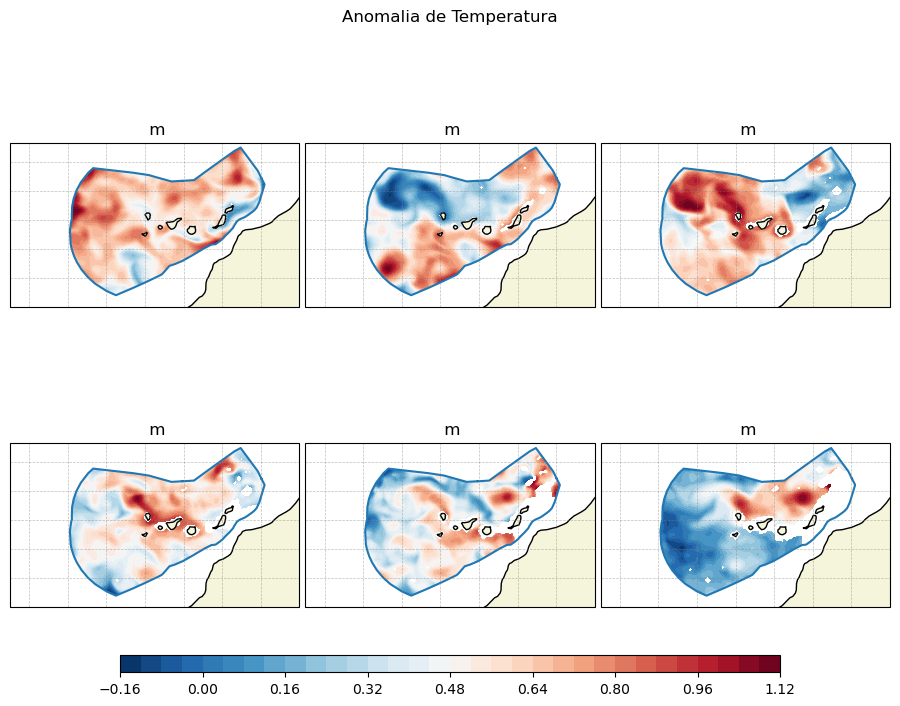

In [43]:
fig, ax = plt.subplots(2,3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
ax=ax.flatten()

depths=np.arange(10,3000,500)
for il in range(0,len(depths)):

    Campo=DC_temp_anom.sel(depth=depths[il], method='nearest')[-1,:,:]
    cs = ax[il].contourf(Campo.longitude,Campo.latitude,Campo, 40, 
               transform=ccrs.PlateCarree(),
               cmap = plt.cm.RdBu.reversed())
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', edgecolor='k', scale = '50m' ,
        facecolor=cfeature.COLORS['land'])

    ax[il].add_feature(land, facecolor='beige')
    

    ax[il].plot(longDem, latiDem, transform=ccrs.PlateCarree())
    ax[il].gridlines(draw_labels=False, linewidth=.5,color='gray', alpha=0.5, linestyle='--')
    #ax[il].top_labels = ax[il].right_labels = False
    ax[il].set_title(' m');


# Delete the unwanted axes
#for i in [7,8]:
#    fig.delaxes(ax[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')

# Add a big title at the top
plt.suptitle('Anomalia de Temperatura');
            

# Weighted mean

In [46]:
weights = np.cos(np.deg2rad(DC_temp.latitude))
weights = weights/weights.max()
weights.name = "weights"

In [47]:
DC_temp_weighted = DC_temp.weighted(weights)
DC_salt_weighted = DC_salt.weighted(weights)

In [48]:
DC_temp_anom_weighted = DC_temp_anom.weighted(weights)
DC_salt_anom_weighted = DC_salt_anom.weighted(weights)

In [49]:
DC_temp_wmean = DC_temp_weighted.mean(("longitude", "latitude"),skipna=True).load()
DC_salt_wmean = DC_salt_weighted.mean(("longitude", "latitude"),skipna=True).load()

In [50]:
DC_temp_anom_wmean = DC_temp_anom_weighted.mean(("longitude", "latitude"),skipna=True).load()
DC_salt_anom_wmean = DC_salt_anom_weighted.mean(("longitude", "latitude"),skipna=True).load()

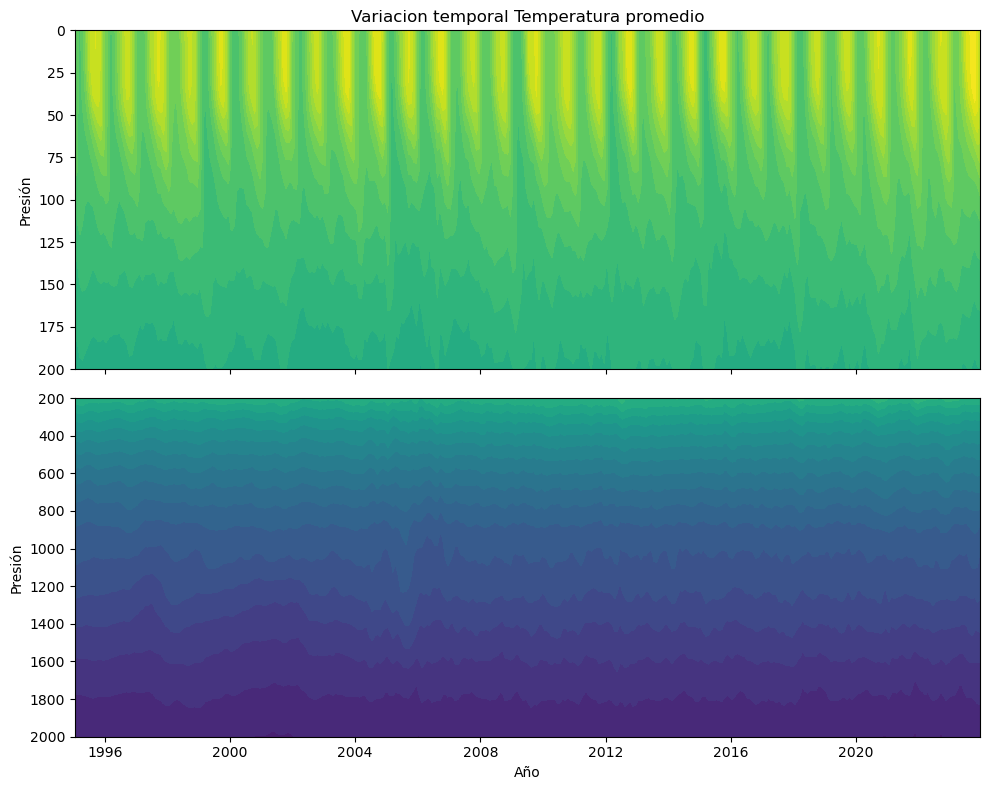

In [51]:
fig, ax = plt.subplots(2, 1 , sharex=True, figsize=(10,8))
ax[0].contourf(DC_temp_wmean.time, DC_temp_wmean.depth, 
            DC_temp_wmean.transpose(), 32)
ax[0].set_title('Variacion temporal Temperatura promedio')
ax[0].set_ylabel('Presión') 
ax[0].invert_yaxis()
ax[0].set_ylim([200,0]);

ax[1].contourf(DC_temp_wmean.time, DC_temp_wmean.depth, 
            DC_temp_wmean.transpose(), 32)
ax[1].set_ylabel('Presión') 
ax[1].set_xlabel('Año')
ax[1].invert_yaxis()
ax[1].set_ylim([2000,200]);

fig.tight_layout()
plt.savefig(imageDir+'/'+titulo_short+'_SeccionTemporal_T.png')

In [52]:
depthi = np.arange(10,4000.5,10)

## Smoothed versions

In [53]:
DCi_temp_wmean = DC_temp_wmean.interp(depth=depthi)
DCi_salt_wmean = DC_temp_wmean.interp(depth=depthi)

DCi_temp_anom_wmean = DC_temp_anom_wmean.interp(depth=depthi)
DCi_salt_anom_wmean = DC_temp_anom_wmean.interp(depth=depthi)

In [54]:
DCi_temp_wmean_rolling = DCi_temp_wmean.rolling(time=12,center=True).mean()
DCi_salt_wmean_rolling = DCi_salt_wmean.rolling(time=12,center=True).mean()

DCi_temp_anom_wmean_rolling = DCi_temp_anom_wmean.rolling(time=12,center=True).mean()
DCi_salt_anom_wmean_rolling = DCi_salt_anom_wmean.rolling(time=12,center=True).mean()

In [55]:
Posiciones=[(0.10, 0.65, 0.8, 0.22),
            (0.10, 0.48, 0.8, 0.165),
            (0.10, 0.10, 0.8, 0.378)]

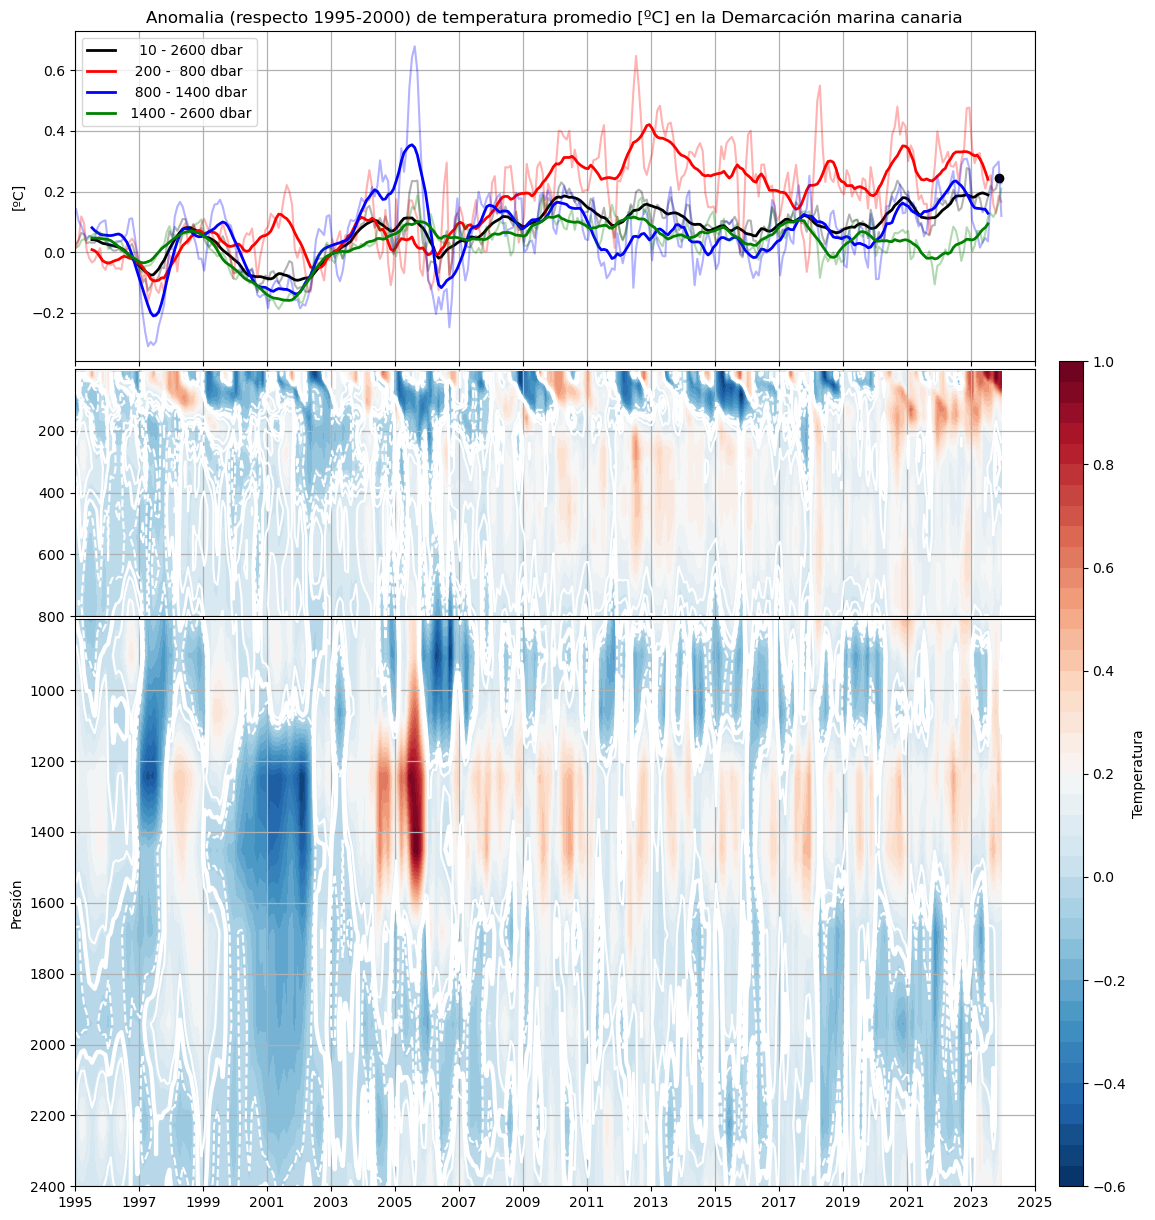

In [56]:
fig, ax = plt.subplots(3,1,figsize = (12,15),sharex=True)


# Mean values
ax[0].plot(DCi_temp_anom_wmean.time[-2],
           DCi_temp_anom_wmean.sel(depth=slice(10,2600)).mean("depth")[-2],'ko')

ax[0].plot(DCi_temp_anom_wmean.time,
           DCi_temp_anom_wmean.sel(depth=slice(10,2600)).mean("depth"),color='k',alpha=0.3)
ax[0].plot(DCi_temp_anom_wmean_rolling.time,
           DCi_temp_anom_wmean_rolling.sel(depth=slice(10,2600)).mean("depth"),linewidth=2,color='k',
           label= '   10 - 2600 dbar')


ax[0].plot(DCi_temp_anom_wmean.time,
           DCi_temp_anom_wmean.sel(depth=slice(200,800)).mean("depth"),color='r',alpha=0.3)
ax[0].plot(DCi_temp_anom_wmean_rolling.time,
           DCi_temp_anom_wmean_rolling.sel(depth=slice(200,800)).mean("depth"),linewidth=2,color='r' ,
           label= '  200 -  800 dbar')

ax[0].plot(DCi_temp_anom_wmean.time,
           DCi_temp_anom_wmean.sel(depth=slice(800,1400)).mean("depth"),color='b',alpha=0.3)
ax[0].plot(DCi_temp_anom_wmean_rolling.time,
           DCi_temp_anom_wmean_rolling.sel(depth=slice(800,1400)).mean("depth"),linewidth=2,color='blue',
           label= '  800 - 1400 dbar')

ax[0].plot(DCi_temp_anom_wmean.time,
           DCi_temp_anom_wmean.sel(depth=slice(1400,2600)).mean("depth"),color='g',alpha=0.3)
ax[0].plot(DCi_temp_anom_wmean_rolling.time,
           DCi_temp_anom_wmean_rolling.sel(depth=slice(1400,2600)).mean("depth"),linewidth=2,color='g',
           label= ' 1400 - 2600 dbar')


ax[0].grid(linestyle='-', linewidth=.9)
ax[0].set_position(Posiciones[0])
ax[0].legend()
ax[0].set_ylabel('[ºC]')
ax[0].set_title('Anomalia (respecto '+yearC1+'-'+yearC2+') de temperatura promedio [ºC] en la '+titulo);


# UpperOcean
ax[1].contour(DCi_temp_anom_wmean.time, DCi_temp_anom_wmean.sel(depth=slice(10,800)).depth, 
              DCi_temp_anom_wmean.sel(depth=slice(10,800)).transpose()
              ,colors='w',levels=[-0.15, -0.05, 0.05, 0.15] )
ax[1].contour(DCi_temp_anom_wmean.time, DCi_temp_anom_wmean.sel(depth=slice(10,800)).depth, 
              DCi_temp_anom_wmean.sel(depth=slice(10,800)).transpose(),colors='w', linewidths=2,
              levels=[0] )

ax[1].contourf(DCi_temp_anom_wmean.time, DCi_temp_anom_wmean.sel(depth=slice(10,800)).depth, 
               DCi_temp_anom_wmean.sel(depth=slice(10,800)).transpose(), 40, cmap='RdBu_r')
              #,levels=np.arange(-0.15,0.15,0.005),extend='both',vmin=-0.2, vmax=0.2)

ax[1].set_ylim(0,800)
ax[1].invert_yaxis()
ax[1].set_yticks([200,400,600,800])
ax[1].grid(linestyle='-', linewidth=.9)
ax[1].set_position(Posiciones[1])

ax[2].contour(DCi_temp_anom_wmean.time, DCi_temp_anom_wmean.sel(depth=slice(800,2600)).depth, 
              DCi_temp_anom_wmean.sel(depth=slice(800,2600)).transpose(),colors='w',
              levels=[-0.05,0.05] )
ax[2].contour(DCi_temp_anom_wmean.time, DCi_temp_anom_wmean.sel(depth=slice(800,2600)).depth, 
              DCi_temp_anom_wmean.sel(depth=slice(800,2600)).transpose(),colors='w', linewidths=3,
              levels=[0] )
cntr2 = ax[2].contourf(DCi_temp_anom_wmean.time, DCi_temp_anom_wmean.sel(depth=slice(800,2600)).depth, 
                      DCi_temp_anom_wmean.sel(depth=slice(800,2600)).transpose(),40,cmap='RdBu_r')
                      #,levels=np.arange(-0.15,0.15,0.005),extend='both')
ax[2].set_ylim(800,2400)
ax[2].invert_yaxis()
ax[2].set_yticks([1000,1200,1400,1600,1800,2000,2200,2400])
ax[2].grid(linestyle='-', linewidth=.9)
ax[2].set_position(Posiciones[2])
ax[2].set_ylabel('Presión')

# Adding the colorbar
cbaxes = fig.add_axes([0.92, 0.1, 0.02, 0.55])  
cb = fig.colorbar(cntr2, cax=cbaxes);
#cbaxes.set_yticks([-0.15, -0.10, -0.05, 0, 0.05, 0.10, 0.15])
cbaxes.set_ylabel('Temperatura')

# xtick Labels
ax[0].set_xticks(pd.date_range(start="1995-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[1].set_xticks(pd.date_range(start="1995-01-01", end="2025-01-01",freq='2YS-JAN'));
ax[2].set_xticks(pd.date_range(start="1995-01-01", end="2025-01-01",freq='2YS-JAN'));

ax[2].set_xticklabels(pd.date_range(start="1995-01-01", end="2025-01-01",freq='2YS-JAN').strftime('%Y'));


plt.savefig(imageDir+'/'+titulo_short+'_temp_promedio_capas_contorno.png')

In [57]:
# Create a Dataset from the DataArrays
Glorys_means = xr.Dataset({
    'DCi_temp_wmean': DC_temp_wmean,
    'DCi_salt_wmean': DC_salt_wmean,
    'DCi_temp_anom_wmean': DC_temp_wmean,
    'DCi_salt_anom_wmean': DC_salt_wmean,
    'DCi_temp_wmean_rolling': DC_temp_wmean,
    'DCi_salt_wmean_rolling': DC_salt_wmean,
    'DCi_temp_anom_wmean_rolling': DC_temp_wmean,
    'DCi_salt_anom_wmean_rolling': DC_salt_wmean
})

In [58]:
Glorys_means.to_netcdf('./Data/Glorys_means'+titulo_short+'.nc')

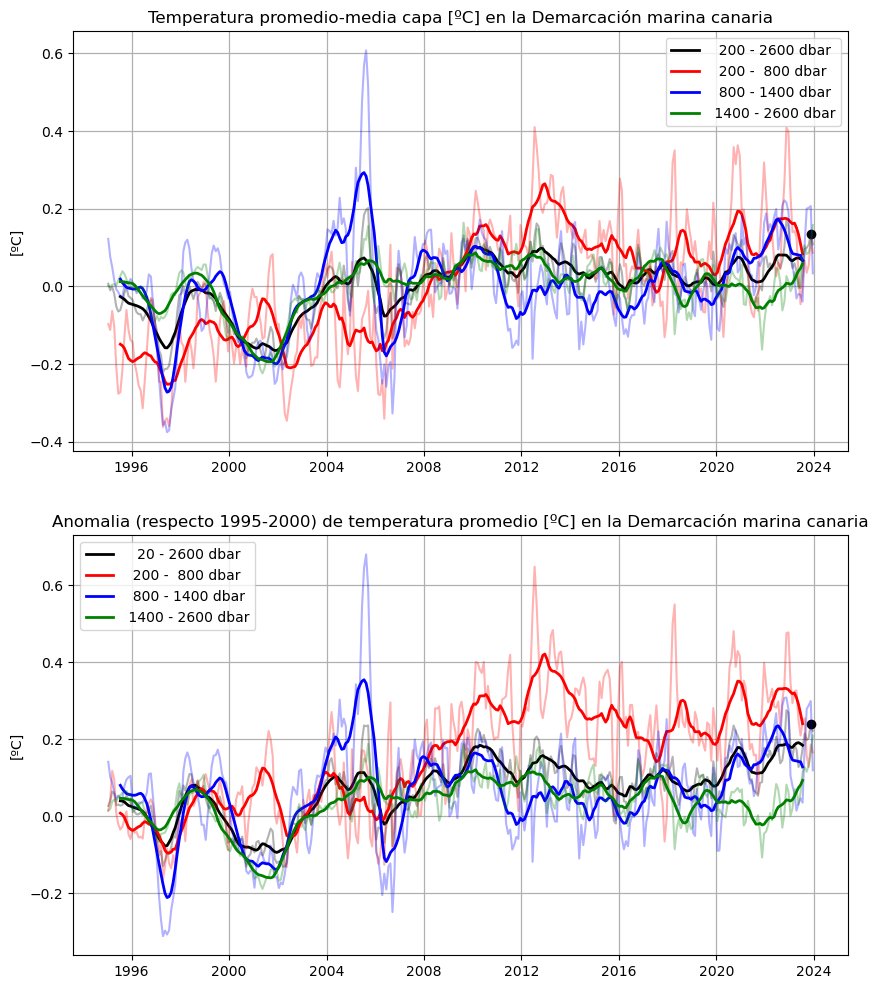

In [59]:
fig, ax = plt.subplots(2,1, figsize=(10,12))

# Mean values
media=DCi_temp_wmean.sel(depth=slice(200,2600)).mean("depth").mean('time')
ax[0].plot(DCi_temp_wmean.time[-2],
           DCi_temp_wmean.sel(depth=slice(200,2600)).mean("depth")[-2]-media,'ko')
ax[0].plot(DCi_temp_wmean.time,
           DCi_temp_wmean.sel(depth=slice(200,2600)).mean("depth")-media,color='k',alpha=0.3)
ax[0].plot(DCi_temp_wmean_rolling.time,
           DCi_temp_wmean_rolling.sel(depth=slice(200,2600)).mean("depth")-media,linewidth=2,color='k',
           label= '  200 - 2600 dbar')


media=DCi_temp_wmean.sel(depth=slice(200,800)).mean("depth").mean('time')
ax[0].plot(DCi_temp_wmean.time,
           DCi_temp_wmean.sel(depth=slice(200,800)).mean("depth")-media,color='r',alpha=0.3)
ax[0].plot(DCi_temp_wmean_rolling.time,
           DCi_temp_wmean_rolling.sel(depth=slice(200,800)).mean("depth")-media,linewidth=2,color='r' ,
           label= '  200 -  800 dbar')

media=DCi_temp_wmean.sel(depth=slice(800,1400)).mean("depth").mean('time')
ax[0].plot(DCi_temp_wmean.time,
           DCi_temp_wmean.sel(depth=slice(800,1400)).mean("depth")-media,color='b',alpha=0.3)
ax[0].plot(DCi_temp_wmean_rolling.time,
           DCi_temp_wmean_rolling.sel(depth=slice(800,1400)).mean("depth")-media,linewidth=2,color='blue',
           label= '  800 - 1400 dbar')

media=DCi_temp_wmean.sel(depth=slice(1400,2600)).mean("depth").mean('time')
ax[0].plot(DCi_temp_wmean.time,
           DCi_temp_wmean.sel(depth=slice(1400,2600)).mean("depth")-media,color='g',alpha=0.3)
ax[0].plot(DCi_temp_wmean_rolling.time,
           DCi_temp_wmean_rolling.sel(depth=slice(1400,2600)).mean("depth")-media,linewidth=2,color='g',
           label= ' 1400 - 2600 dbar')

ax[0].grid(linestyle='-', linewidth=.9)
ax[0].legend()
ax[0].set_ylabel('[ºC]')
ax[0].set_title('Temperatura promedio-media capa [ºC] en la '+titulo);

# Anomalias
ax[1].plot(DCi_temp_anom_wmean.time[-2],
           DCi_temp_anom_wmean.sel(depth=slice(20,2600)).mean("depth")[-2],'ko')

ax[1].plot(DCi_temp_anom_wmean.time,
           DCi_temp_anom_wmean.sel(depth=slice(20,2600)).mean("depth"),color='k',alpha=0.3)
ax[1].plot(DCi_temp_anom_wmean_rolling.time,
           DCi_temp_anom_wmean_rolling.sel(depth=slice(20,2600)).mean("depth"),linewidth=2,color='k',
           label= '   20 - 2600 dbar')


ax[1].plot(DCi_temp_anom_wmean.time,
           DCi_temp_anom_wmean.sel(depth=slice(200,800)).mean("depth"),color='r',alpha=0.3)
ax[1].plot(DCi_temp_anom_wmean_rolling.time,
           DCi_temp_anom_wmean_rolling.sel(depth=slice(200,800)).mean("depth"),linewidth=2,color='r' ,
           label= '  200 -  800 dbar')

ax[1].plot(DCi_temp_anom_wmean.time,
           DCi_temp_anom_wmean.sel(depth=slice(800,1400)).mean("depth"),color='b',alpha=0.3)
ax[1].plot(DCi_temp_anom_wmean_rolling.time,
           DCi_temp_anom_wmean_rolling.sel(depth=slice(800,1400)).mean("depth"),linewidth=2,color='blue',
           label= '  800 - 1400 dbar')

ax[1].plot(DCi_temp_anom_wmean.time,
           DCi_temp_anom_wmean.sel(depth=slice(1400,2600)).mean("depth"),color='g',alpha=0.3)
ax[1].plot(DCi_temp_anom_wmean_rolling.time,
           DCi_temp_anom_wmean_rolling.sel(depth=slice(1400,2600)).mean("depth"),linewidth=2,color='g',
           label= ' 1400 - 2600 dbar')


ax[1].grid(linestyle='-', linewidth=.9)
ax[1].legend()
ax[1].set_ylabel('[ºC]')
ax[1].set_title('Anomalia (respecto '+yearC1+'-'+yearC2+') de temperatura promedio [ºC] en la '+titulo);


plt.savefig(imageDir+'/'+titulo_short+'_temp_promedio_capas.png')